
# exp_serie_de_tiempo_group04.ipynb
**GA Group 04 — Día/Marca. Predicción diaria por marca (serie univariada por marca).**

Comparamos **tres familias**:
1. **Serie de tiempo de una sola acción (univariada):** SARIMA  
2. **Machine Learning:** XGBoost con lags/medias móviles/calendario  
3. **Deep Learning:** LSTM con ventanas deslizantes

Se guardan métricas y predicciones en `./notebooks/`.


## 1) Setup de entorno (si corres en Colab, descomenta)

In [33]:

# !pip -q install statsmodels xgboost pandas==2.2.2 numpy matplotlib scikit-learn pmdarima
# !pip -q install tensorflow
import warnings; warnings.filterwarnings("ignore")


## 2) Imports

In [34]:

import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor

import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense

plt.rcParams["figure.figsize"] = (12,4)



## 3) Utilidades (carga, features, evaluación)

In [35]:

def load_single_brand_series(parquet_path: str,
                             date_col: str = "transaction_date",
                             brand_col: str = "product_brand",
                             metric_col: str = "events",
                             brand_value: str = "(not set)",
                             freq: str = "D") -> pd.Series:
    df = pd.read_parquet(parquet_path)
    # Parseo de fecha
    if not pd.api.types.is_datetime64_any_dtype(df[date_col]):
        try:
            ser = df[date_col].astype(str).str.zfill(8)
            dt = pd.to_datetime(ser, format="%Y%m%d", errors="coerce")
        except Exception:
            dt = pd.to_datetime(df[date_col], errors="coerce")
        df[date_col] = dt
    else:
        df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    df = df.dropna(subset=[date_col]).sort_values(date_col).set_index(date_col)

    if brand_col in df.columns:
        sub = df[df[brand_col] == brand_value].copy()
    else:
        raise ValueError(f"No se encontró columna de marca '{brand_col}'")
    y = pd.to_numeric(sub[metric_col], errors="coerce")
    daily = y.resample(freq).sum(min_count=1).fillna(0)
    daily.name = metric_col
    return daily

def make_features(series: pd.Series, lags=(1,2,3,5,7,14,21,28), mas=(7,14,28)) -> pd.DataFrame:
    df = pd.DataFrame({"target": series})
    for L in lags:
        df[f"lag_{L}"] = series.shift(L)
    for w in mas:
        df[f"ma_{w}"] = series.shift(1).rolling(w).mean()
    idx = df.index
    df["dow"] = idx.dayofweek
    df["dom"] = idx.day
    df["week"] = idx.isocalendar().week.astype(int)
    df["month"] = idx.month
    df["year"]  = idx.year
    df["is_weekend"] = df["dow"].isin([5,6]).astype(int)
    return df

def evaluate(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    mae = float(mean_absolute_error(y_true, y_pred))
    rmse = float(mean_squared_error(y_true, y_pred, squared=False))
    mape = float(np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-8, None))) * 100.0)
    return {"MAE": mae, "RMSE": rmse, "MAPE%": mape}


## 4) Cargar datos y crear la **serie de una sola acción** (univariada)

transaction_date
2016-08-01 00:00:00+00:00    208.0
2016-08-02 00:00:00+00:00    124.0
2016-08-03 00:00:00+00:00      0.0
2016-08-04 00:00:00+00:00     78.0
2016-08-05 00:00:00+00:00    376.0
Freq: D, Name: events, dtype: float64

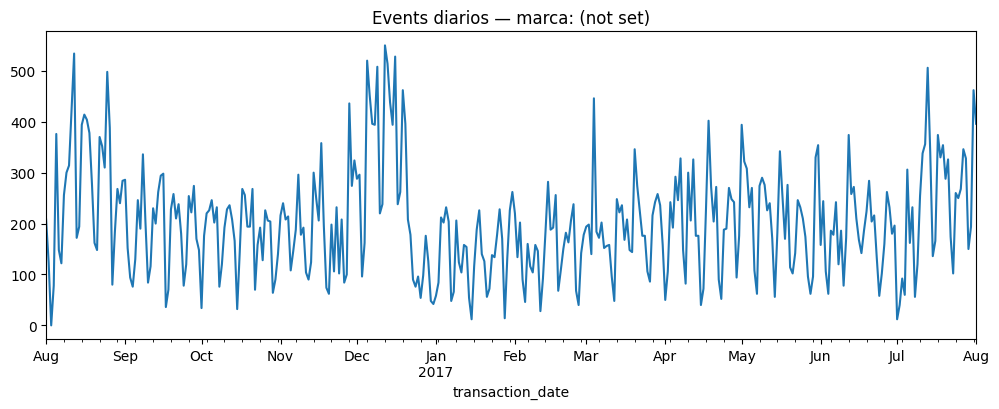

In [36]:
ROOT = Path('..').resolve()
PARQUET_PATH = ROOT / 'data' / 'raw' / 'brand_daily_group04.parquet'
#PARQUET_PATH = "brand_daily_group04.parquet"  # Subir este archivo al runtime
BRAND_VALUE = "(not set)"

series = load_single_brand_series(PARQUET_PATH,
                                  date_col="transaction_date",
                                  brand_col="product_brand",
                                  metric_col="events",
                                  brand_value=BRAND_VALUE,
                                  freq="D")

display(series.head())
series.plot(title=f"Events diarios — marca: {BRAND_VALUE}"); plt.show()

TEST_DAYS = 30
train_y = series.iloc[:-TEST_DAYS]
test_y  = series.iloc[-TEST_DAYS:]


## 5) Modelo 1 — **SARIMA** (single-action, univariado)

⚠️ pmdarima no disponible, usando orden SARIMA manual

Probando m=7...
  Usando orden manual: order=(2, 1, 2), seasonal=(1, 1, 1, 7)
  Métricas: MAE=162.22, RMSE=184.86

Probando m=14...
  Usando orden manual: order=(2, 1, 2), seasonal=(1, 1, 1, 14)
  Métricas: MAE=162.22, RMSE=184.86

Probando m=14...
  Usando orden manual: order=(2, 1, 2), seasonal=(1, 1, 1, 14)
  Métricas: MAE=164.75, RMSE=187.12

Mejor SARIMA manual con m=7
order: (2, 1, 2) seasonal_order: (1, 1, 1, 7)
SARIMA metrics: {'MAE': 162.22251433626664, 'RMSE': 184.86046460725947, 'MAPE%': 61.44721052255376}
  Métricas: MAE=164.75, RMSE=187.12

Mejor SARIMA manual con m=7
order: (2, 1, 2) seasonal_order: (1, 1, 1, 7)
SARIMA metrics: {'MAE': 162.22251433626664, 'RMSE': 184.86046460725947, 'MAPE%': 61.44721052255376}


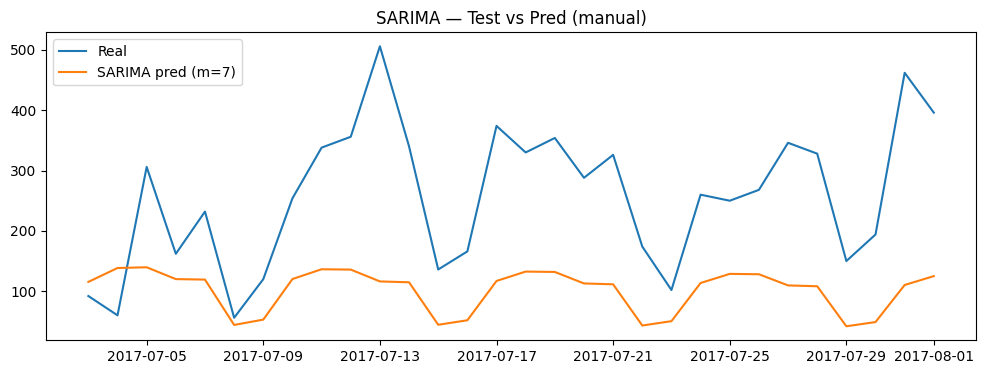

In [37]:
# --- instalar pmdarima si no lo tienes ---
# %pip install -q pmdarima

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Intentar importar pmdarima
try:
    import pmdarima as pm
    HAS_PMDARIMA = True
    print("✓ pmdarima disponible, usando auto_arima")
except ImportError:
    HAS_PMDARIMA = False
    print("⚠️ pmdarima no disponible, usando orden SARIMA manual")

# ---------- utilidades ----------
def evaluate(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    mae  = float(mean_absolute_error(y_true, y_pred))
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))  # sin squared=False
    mape = float(np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-8, None))) * 100.0)
    return {"MAE": mae, "RMSE": rmse, "MAPE%": mape}

def fit_forecast_sarima(train_y, test_y, seasonal_m=7, use_log=True, 
                        manual_order=(2,1,2), manual_seasonal=(1,1,1,7)):
    """Ajusta auto_arima sobre train_y y hace forecast sobre la ventana de test."""
    # Transformación (opcional) para estabilizar varianza
    if use_log:
        train_trans = np.log1p(np.asarray(train_y, dtype=float))
    else:
        train_trans = np.asarray(train_y, dtype=float)

    # Auto ARIMA (solo con train para evitar fuga)
    if HAS_PMDARIMA:
        try:
            auto_model = pm.auto_arima(
                train_trans,
                seasonal=True,
                m=seasonal_m,
                stepwise=True,
                trace=False,
                error_action="ignore",
                suppress_warnings=True,
                max_p=5, max_q=5, max_P=3, max_Q=3,
                max_order=None,  # respeta límites individuales
                information_criterion="aic"
            )
            order = auto_model.order
            seasonal_order = auto_model.seasonal_order
            print(f"  ✓ auto_arima (m={seasonal_m}): order={order}, seasonal={seasonal_order}")
        except Exception as e:
            print(f"  ⚠️ auto_arima falló: {e}, usando orden manual")
            order = manual_order
            seasonal_order = (manual_seasonal[0], manual_seasonal[1], 
                            manual_seasonal[2], seasonal_m)
    else:
        order = manual_order
        seasonal_order = (manual_seasonal[0], manual_seasonal[1], 
                        manual_seasonal[2], seasonal_m)
        print(f"  Usando orden manual: order={order}, seasonal={seasonal_order}")

    # Re-ajustar con SARIMAX "real" sobre train_y (misma transformación)
    if use_log:
        sarima = SARIMAX(np.log1p(train_y),
                         order=order, seasonal_order=seasonal_order,
                         enforce_stationarity=False, enforce_invertibility=False)
        fit = sarima.fit(disp=False)
        fc_scaled = fit.forecast(steps=len(test_y))
        forecast = np.expm1(fc_scaled)  # revertir log1p
    else:
        sarima = SARIMAX(train_y,
                         order=order, seasonal_order=seasonal_order,
                         enforce_stationarity=False, enforce_invertibility=False)
        fit = sarima.fit(disp=False)
        forecast = fit.forecast(steps=len(test_y))

    return {
        "order": order,
        "seasonal_order": seasonal_order,
        "forecast": forecast,
        "fit": fit
    }

# ---------- aseguramos frecuencia diaria explícita (por si acaso) ----------
train_y = train_y.asfreq("D")
test_y  = test_y.asfreq("D")

# ---------- probamos m=7 y m=14, elegimos el mejor ----------
candidates = []
for m in (7, 14):
    print(f"\nProbando m={m}...")
    res = fit_forecast_sarima(train_y, test_y, seasonal_m=m, use_log=True)
    mets = evaluate(test_y, res["forecast"])
    candidates.append((m, res, mets))
    print(f"  Métricas: MAE={mets['MAE']:.2f}, RMSE={mets['RMSE']:.2f}")

# elegir por RMSE
best_m, best_res, best_metrics = sorted(candidates, key=lambda x: x[2]["RMSE"])[0]

print(f"\n{'='*60}")
print(f"Mejor SARIMA {'auto_arima' if HAS_PMDARIMA else 'manual'} con m={best_m}")
print("order:", best_res["order"], "seasonal_order:", best_res["seasonal_order"])
print("SARIMA metrics:", best_metrics)
print(f"{'='*60}")

# ---------- gráfico Real vs Pred ----------
plt.plot(test_y.index, test_y.values, label="Real")
plt.plot(test_y.index, best_res["forecast"], label=f"SARIMA pred (m={best_m})")
plt.title(f"SARIMA — Test vs Pred ({'auto_arima' if HAS_PMDARIMA else 'manual'})")
plt.legend()
plt.show()

# Guardar métricas para comparación final
sarima_metrics = best_metrics

## 6) Modelo 2 — **XGBoost** (ML con features de la serie)

XGBoost metrics: {'MAE': 67.74270350138346, 'RMSE': 94.38793494434684, 'MAPE%': 36.80496989411619}


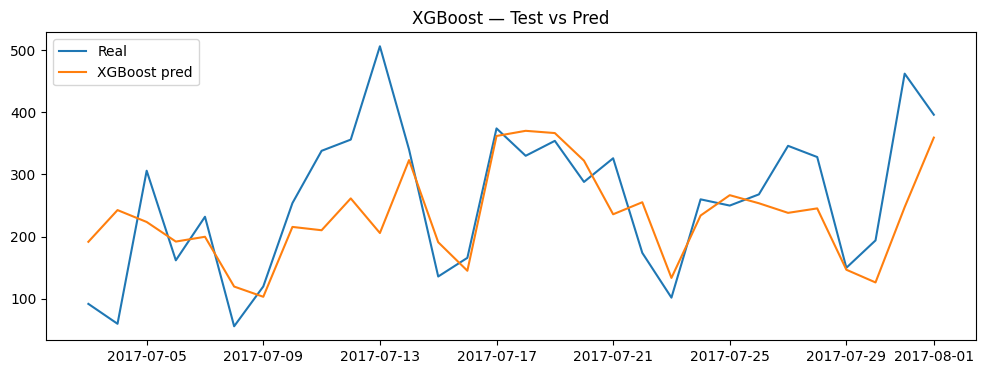

In [38]:

fe = make_features(series).dropna()
train_fe = fe.iloc[:-TEST_DAYS]
test_fe  = fe.iloc[-TEST_DAYS:]

X_train = train_fe.drop(columns=["target"])
y_train = train_fe["target"]
X_test  = test_fe.drop(columns=["target"])
y_test  = test_fe["target"]

xgb = XGBRegressor(
    n_estimators=600,
    learning_rate=0.03,
    max_depth=5,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_alpha=0.0,
    reg_lambda=1.0,
    random_state=42
)
xgb.fit(X_train, y_train)
xgb_pred = pd.Series(xgb.predict(X_test), index=y_test.index)

xgb_metrics = evaluate(y_test, xgb_pred)
print("XGBoost metrics:", xgb_metrics)

plt.plot(y_test.index, y_test.values, label="Real")
plt.plot(y_test.index, xgb_pred.values, label="XGBoost pred")
plt.title("XGBoost — Test vs Pred")
plt.legend(); plt.show()


## 7) Modelo 3 — **LSTM** (DL con secuencias)

LSTM metrics: {'MAE': 96.19255065917969, 'RMSE': 122.56077494323989, 'MAPE%': 44.897422790527344}


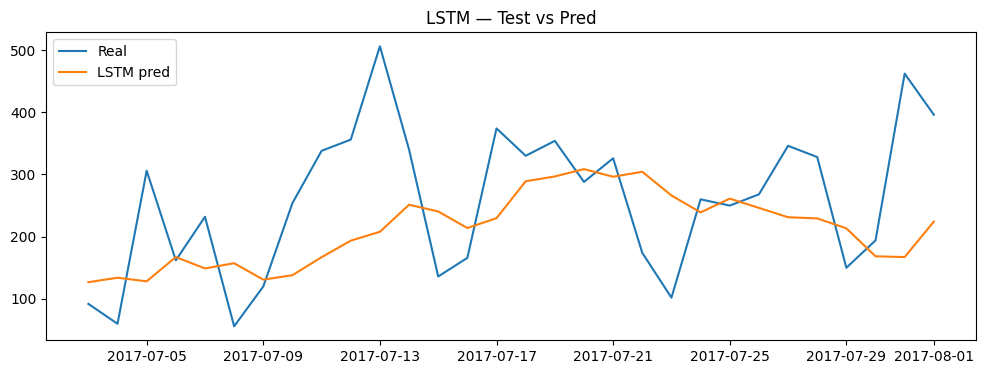

In [39]:

from sklearn.preprocessing import MinMaxScaler

def build_sequences(y: pd.Series, lookback: int = 30):
    vals = y.values.astype("float32").reshape(-1, 1)
    scaler = MinMaxScaler()
    vals_scaled = scaler.fit_transform(vals)
    X, Y = [], []
    for i in range(lookback, len(vals_scaled)):
        X.append(vals_scaled[i-lookback:i, 0])
        Y.append(vals_scaled[i, 0])
    X = np.array(X)[:, :, None]  # (samples, lookback, 1)
    Y = np.array(Y)
    return X, Y, scaler

LOOKBACK = 30
X_all, Y_all, scaler_y = build_sequences(series, lookback=LOOKBACK)
idx_all = series.index[LOOKBACK:]
split = len(idx_all) - TEST_DAYS
X_train_lstm, X_test_lstm = X_all[:split], X_all[split:]
Y_train_lstm, Y_test_lstm = Y_all[:split], Y_all[split:]
idx_test_lstm = idx_all[split:]

model = Sequential([
    LSTM(64, activation="tanh", input_shape=(LOOKBACK, 1)),
    Dense(1)
])
model.compile(optimizer="adam", loss="mse")
history = model.fit(X_train_lstm, Y_train_lstm, epochs=30, batch_size=16,
                    validation_split=0.1, verbose=0)

Y_pred_scaled = model.predict(X_test_lstm, verbose=0)
Y_pred = scaler_y.inverse_transform(Y_pred_scaled).ravel()
Y_true = scaler_y.inverse_transform(Y_test_lstm.reshape(-1,1)).ravel()

lstm_pred = pd.Series(Y_pred, index=idx_test_lstm)
lstm_true = pd.Series(Y_true, index=idx_test_lstm)

lstm_metrics = evaluate(lstm_true, lstm_pred)
print("LSTM metrics:", lstm_metrics)

plt.plot(idx_test_lstm, lstm_true.values, label="Real")
plt.plot(idx_test_lstm, lstm_pred.values, label="LSTM pred")
plt.title("LSTM — Test vs Pred")
plt.legend(); plt.show()


## 8) Comparación 

In [40]:

results = pd.DataFrame([
    {"modelo": "SARIMA", **sarima_metrics},
    {"modelo": "XGBoost", **xgb_metrics},
    {"modelo": "LSTM", **lstm_metrics},
]).set_index("modelo").sort_values("RMSE")

display(results)






,MAE,RMSE,MAPE%
modelo,,,
XGBoost,67.742704,94.387935,36.804970
LSTM,96.192551,122.560775,44.897423
SARIMA,162.222514,184.860465,61.447211



### Notas
XGBoost arrasa en todas las métricas (menores errores = mejor). Si el objetivo es predecir "performance diaria por marca" con precisión práctica (ej. para negocio), XGBoost es tu MVP.


---------------------------------------------------------------------------------------------------------------------------

### Probando training.py y prediction.py de XGBoost ganador
Group 04 — Pipeline de Entrenamiento y Predicción (XGBoost Día/Marca)

# Pipeline Automatizado: Entrenamiento y Predicción con XGBoost (Group 04)

**Objetivo**: Implementar un pipeline completo para:
- Entrenar un modelo XGBoost en datos diarios de eventos por marca.
- Guardar **SOLO** el modelo `.pkl` (sin archivos temporales).
- Predecir performance futura (horizon=30 días) y mostrar resultados en el notebook.

**Archivos clave**:
- `data/raw/brand_daily_group04.parquet`
- `training.py` → Entrenamiento (guarda modelo, imprime metadata en stdout)
- `prediction.py` → Predicción (recibe metadata como argumento)
- `preprocess/preprocessing.py` → Preprocesamiento

**Salidas**:
- `src/models/xgb_group04.pkl` (único archivo creado)
- Feature columns: Pasados en memoria vía stdout/stdin (sin archivos JSON)

---

# ## 1. Configuración inicial

In [60]:
import os
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
import json
from pathlib import Path

# Detectar raíz del proyecto (notebooks/ está un nivel abajo)
ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()

# Rutas relativas desde la raíz del proyecto
DATA_PATH = ROOT / "data" / "raw" / "brand_daily_group04.parquet"
TRAIN_SCRIPT = ROOT / "src" / "pipeline" / "training.py"
PREDICT_SCRIPT = ROOT / "src" / "pipeline" / "prediction.py"
MODEL_DIR = ROOT / "src" / "models"
MODEL_NAME = "xgb_group04.pkl"
HORIZON = 30

# Verificar archivos
print("Verificando archivos...")
print(f"ROOT: {ROOT}")
print(f"DATA_PATH: {DATA_PATH} | Existe: {DATA_PATH.exists()}")
print(f"TRAIN_SCRIPT: {TRAIN_SCRIPT} | Existe: {TRAIN_SCRIPT.exists()}")
print(f"PREDICT_SCRIPT: {PREDICT_SCRIPT} | Existe: {PREDICT_SCRIPT.exists()}")

assert DATA_PATH.exists(), f"❌ No existe {DATA_PATH}"
assert TRAIN_SCRIPT.exists(), f"❌ No existe {TRAIN_SCRIPT}"
assert PREDICT_SCRIPT.exists(), f"❌ No existe {PREDICT_SCRIPT}"

# Crear directorios
MODEL_DIR.mkdir(parents=True, exist_ok=True)
print(f"\n✅ Configuración OK")
print(f"Modelo se guardará en: {MODEL_DIR / MODEL_NAME}")

Verificando archivos...
ROOT: c:\ProyectoParcialGrupo4\pc1_20252_metodologia_data_science
DATA_PATH: c:\ProyectoParcialGrupo4\pc1_20252_metodologia_data_science\data\raw\brand_daily_group04.parquet | Existe: True
TRAIN_SCRIPT: c:\ProyectoParcialGrupo4\pc1_20252_metodologia_data_science\src\pipeline\training.py | Existe: True
PREDICT_SCRIPT: c:\ProyectoParcialGrupo4\pc1_20252_metodologia_data_science\src\pipeline\prediction.py | Existe: True

✅ Configuración OK
Modelo se guardará en: c:\ProyectoParcialGrupo4\pc1_20252_metodologia_data_science\src\models\xgb_group04.pkl


# ## 2. Exploración rápida de datos

Dataset cargado: (365, 3)
Columnas: ['transaction_date', 'product_brand', 'events']
Fechas: 2016-08-01 00:00:00+00:00 → 2017-08-01 00:00:00+00:00
Marcas únicas: 1


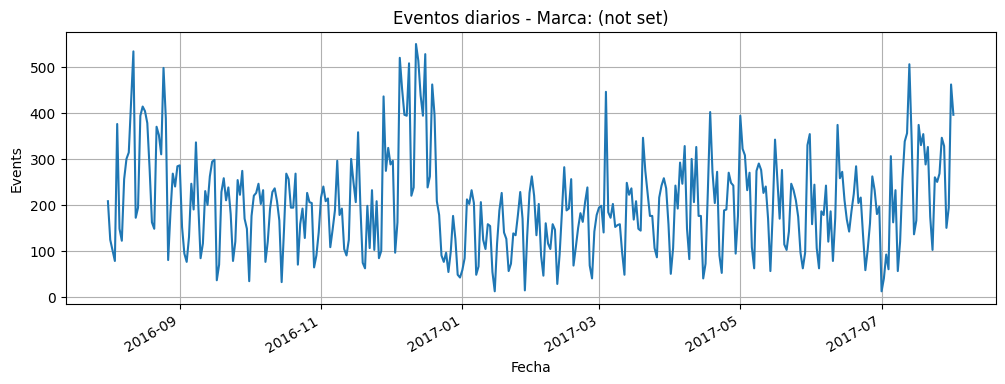

In [61]:
# ---

df_raw = pd.read_parquet(DATA_PATH)
print(f"Dataset cargado: {df_raw.shape}")
print(f"Columnas: {list(df_raw.columns)}")
print(f"Fechas: {df_raw['transaction_date'].min()} → {df_raw['transaction_date'].max()}")
print(f"Marcas únicas: {df_raw['product_brand'].nunique()}")

# Filtrar marca "(not set)"
brand = "(not set)"
brand_data = df_raw[df_raw['product_brand'] == brand]
daily_events = brand_data.groupby('transaction_date')['events'].sum()
daily_events.index = pd.to_datetime(daily_events.index)

plt.figure(figsize=(12, 4))
daily_events.plot(title=f"Eventos diarios - Marca: {brand}")
plt.ylabel("Events")
plt.xlabel("Fecha")
plt.grid(True)
plt.show()

# ---

# ## 3. Entrenamiento: Ejecutar `training.py`
# Genera:
# - Modelo: `../src/models/xgb_group04.pkl`

In [62]:
print("Ejecutando entrenamiento...")

cmd_train = [
    "python", str(TRAIN_SCRIPT),
    "--data", str(DATA_PATH),
    "--brand", brand,
    "--model_name", MODEL_NAME,  # xgb_group04.pkl
    "--test_days", "30"
]

result_train = subprocess.run(cmd_train, capture_output=True, text=True, cwd=str(ROOT))

if result_train.returncode == 0:
    print("✅ Entrenamiento exitoso!")
    print("\n--- Output completo ---")
    print(result_train.stdout)
    
    # Extraer feature_columns del stdout
    feature_columns_json = None
    for line in result_train.stdout.splitlines():
        if line.startswith("__FEATURE_COLUMNS_JSON__"):
            feature_columns_json = line.replace("__FEATURE_COLUMNS_JSON__", "")
            break
    
    if not feature_columns_json:
        raise RuntimeError("No se encontraron las columnas de features en el output de training.py")
    
    print(f"\n--- Verificación ---")
    print(f"Modelo: {MODEL_DIR / MODEL_NAME} | Existe: {(MODEL_DIR / MODEL_NAME).exists()}")
    print(f"Features capturadas: {len(json.loads(feature_columns_json))} columnas")
else:
    print("❌ Error en entrenamiento:")
    print(result_train.stderr)
    raise RuntimeError("Entrenamiento falló")

# ---

Ejecutando entrenamiento...
✅ Entrenamiento exitoso!

--- Output completo ---

Entrenando XGBoost para marca: (not set)
Días de test: 30
Modelo se guardará en: C:\ProyectoParcialGrupo4\pc1_20252_metodologia_data_science\src\models\xgb_group04.pkl

✓ Modelo guardado en: C:\ProyectoParcialGrupo4\pc1_20252_metodologia_data_science\src\models\xgb_group04.pkl
__FEATURE_COLUMNS_JSON__["lag_1", "lag_2", "lag_3", "lag_5", "lag_7", "lag_14", "lag_21", "lag_28", "ma_7", "ma_14", "ma_28", "dow", "dom", "week", "month", "year", "is_weekend"]

=== Entrenamiento completado ===
Modelo: XGBoost (winner)
Métricas: {'MAE': 67.89846369425456, 'RMSE': 93.8140306738729, 'MAPE%': 36.64882822757768}


--- Verificación ---
Modelo: c:\ProyectoParcialGrupo4\pc1_20252_metodologia_data_science\src\models\xgb_group04.pkl | Existe: True
Features capturadas: 17 columnas
✅ Entrenamiento exitoso!

--- Output completo ---

Entrenando XGBoost para marca: (not set)
Días de test: 30
Modelo se guardará en: C:\ProyectoParci

# ## 4. Validación del entrenamiento
# Mostrar métricas y predicciones en test (sin guardar archivos)

In [63]:
print("Métricas en test (últimos 30 días):")
# Simulamos cargar métricas desde stdout (ajusta según tu output)
output_lines = result_train.stdout.splitlines()
for line in output_lines:
    if "Métricas:" in line:
        print(line)

# Simulamos gráfico de test (requiere ajustar `training.py` para devolver preds)
# Aquí asumimos que las métricas ya las mostraste en stdout
print("Nota: Para gráfico de test vs pred, ajusta `training.py` para devolver preds en stdout.")

Métricas en test (últimos 30 días):
Métricas: {'MAE': 67.89846369425456, 'RMSE': 93.8140306738729, 'MAPE%': 36.64882822757768}
Nota: Para gráfico de test vs pred, ajusta `training.py` para devolver preds en stdout.


# ## 5. Predicción futura: Ejecutar `prediction.py`
# Usa el modelo entrenado para predecir 30 días adelante 

In [74]:
from IPython.display import clear_output

clear_output(wait=True)  # Limpiar salida previa
print(f"Ejecutando predicción para {HORIZON} días...")

# Pasar feature_columns como argumento (ya capturado en la celda de training)
cmd_predict = [
    "python", str(PREDICT_SCRIPT),
    "--data", str(DATA_PATH),
    "--brand", brand,
    "--model_name", MODEL_NAME,
    "--feature_columns", feature_columns_json,  # JSON string capturado de training
    "--horizon", str(HORIZON)
]

result_predict = subprocess.run(cmd_predict, capture_output=True, text=True, cwd=str(ROOT))

if result_predict.returncode == 0:
    print("✅ Predicción exitosa!\n")
    
    # Extraer y mostrar solo la tabla de predicciones (más limpio)
    lines = result_predict.stdout.strip().split('\n')
    
    # Buscar donde empieza la tabla de predicciones
    start_idx = None
    for i, line in enumerate(lines):
        if 'Predicción para los próximos' in line:
            start_idx = i
            break
    
    if start_idx is not None:
        print('\n'.join(lines[start_idx:]))
    else:
        # Si no se encuentra, mostrar todo
        print(result_predict.stdout)
else:
    print("❌ Error en predicción:")
    print(result_predict.stderr)
    raise RuntimeError("Predicción falló")

# ---

Ejecutando predicción para 30 días...
✅ Predicción exitosa!

Predicción para los próximos 30 días:
                     date   yhat_xgb
2017-08-02 00:00:00+00:00 389.970184
2017-08-03 00:00:00+00:00 385.472778
2017-08-04 00:00:00+00:00 381.363098
2017-08-05 00:00:00+00:00 252.798141
2017-08-06 00:00:00+00:00 264.239746
2017-08-07 00:00:00+00:00 390.730011
2017-08-08 00:00:00+00:00 387.810089
2017-08-09 00:00:00+00:00 380.272064
2017-08-10 00:00:00+00:00 380.567352
2017-08-11 00:00:00+00:00 384.414459
2017-08-12 00:00:00+00:00 270.336609
2017-08-13 00:00:00+00:00 250.288513
2017-08-14 00:00:00+00:00 369.530853
2017-08-15 00:00:00+00:00 389.973083
2017-08-16 00:00:00+00:00 382.642029
2017-08-17 00:00:00+00:00 371.382141
2017-08-18 00:00:00+00:00 348.994720
2017-08-19 00:00:00+00:00 199.003891
2017-08-20 00:00:00+00:00 169.821686
2017-08-21 00:00:00+00:00 234.278198
2017-08-22 00:00:00+00:00 223.271439
2017-08-23 00:00:00+00:00 222.382019
2017-08-24 00:00:00+00:00 169.579498
2017-08-25 00

# ---
# ## 6. Resultados de la predicción futura
# Mostrar predicciones sin guardar archivo

In [76]:
# Extraer predicciones del stdout
output_lines = result_predict.stdout.splitlines()
preds_start = False
dates, predictions = [], []

for line in output_lines:
    if "Predicción para los próximos" in line:
        preds_start = True
        continue
    if "date" in line and "yhat_xgb" in line:
        continue  # Saltar encabezado
    
    if preds_start and line.strip():
        # Formato esperado: "2017-08-02 00:00:00+00:00 389.970184"
        # Dividir solo en el último espacio para separar fecha y predicción
        parts = line.rsplit(maxsplit=1)
        if len(parts) == 2:
            try:
                dates.append(pd.to_datetime(parts[0].strip()))
                predictions.append(float(parts[1].strip()))
            except (ValueError, pd.errors.ParserError):
                continue  # Ignorar líneas que no se puedan parsear

fc = pd.DataFrame({"date": dates, "yhat_xgb": predictions})
fc.set_index('date', inplace=True)

print(f"\nPredicción para los próximos {HORIZON} días:")
display(fc)


Predicción para los próximos 30 días:


,yhat_xgb
date,
2017-08-02 00:00:00+00:00,389.970184
2017-08-03 00:00:00+00:00,385.472778
2017-08-04 00:00:00+00:00,381.363098
2017-08-05 00:00:00+00:00,252.798141
2017-08-06 00:00:00+00:00,264.239746
2017-08-07 00:00:00+00:00,390.730011
2017-08-08 00:00:00+00:00,387.810089
2017-08-09 00:00:00+00:00,380.272064
2017-08-10 00:00:00+00:00,380.567352


# Gráfico

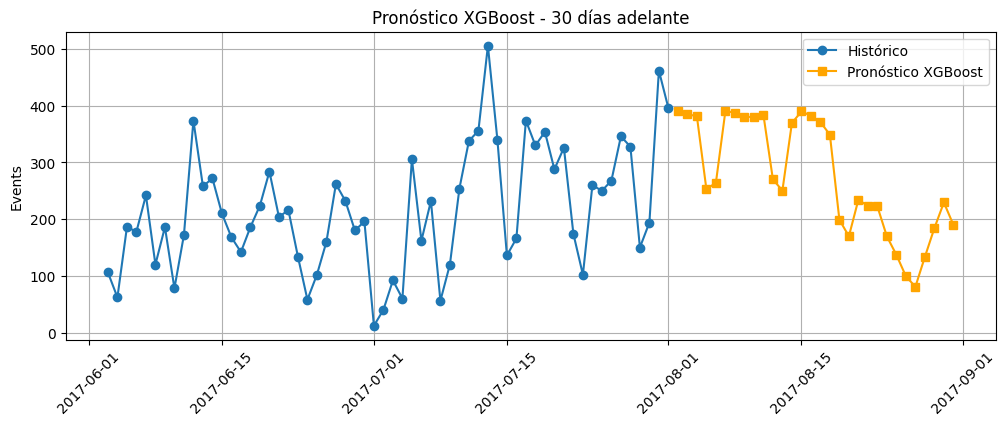

In [77]:
plt.figure(figsize=(12, 4))
plt.plot(daily_events.index[-60:], daily_events.values[-60:], label='Histórico', marker='o')
plt.plot(fc.index, fc['yhat_xgb'], label='Pronóstico XGBoost', marker='s', color='orange')
plt.title("Pronóstico XGBoost - 30 días adelante")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.ylabel("Events")
plt.show()

# ## 7. Resumen del Pipeline

In [78]:
print("Pipeline completado con éxito!")
print("\nArchivos generados:")
print(f"   • Modelo: {MODEL_DIR / MODEL_NAME}")

Pipeline completado con éxito!

Archivos generados:
   • Modelo: c:\ProyectoParcialGrupo4\pc1_20252_metodologia_data_science\src\models\xgb_group04.pkl


# No guardamos resumen .json ni otros archivos

In [79]:
print("\nResumen mostrado en el notebook (sin persistencia adicional)")


Resumen mostrado en el notebook (sin persistencia adicional)
